## Introduction
In this Notebook, I show how to build a multiclass classifier, by:
 - applying simple pre-processing steps
 - trying different baseline algorithms
 - optimizing the hyperparameters of XGBoost, LightGBM
 
 
 - using all the training data.
 - using 5-fold stratified splitting and computing the average predicted probabilities out of 5
 - Enable cross-validation, stacking, and voting
 - I omit the detailed visualization of the EDA


# 0. import Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import cross_validate
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier

# 1. import data
We import the data and we create two subsets:
 - one with numerical data
 - one with categorical data

In [3]:
# Load the training data into a DataFrame and create a derived variable named 'BMI'.
df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv', index_col = 0)
df.head()

df["BMI"] = df["Weight"]/(df["Height"]*df["Height"])
df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
id,,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight,23.422091
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight,17.126706
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III,44.855798
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II,25.599151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II,36.587084
20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight,17.099278
20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II,31.889841


In [5]:
# Confirm that there are no missing values in the training data.
df.isnull().sum()

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
BMI                               0
dtype: int64

['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


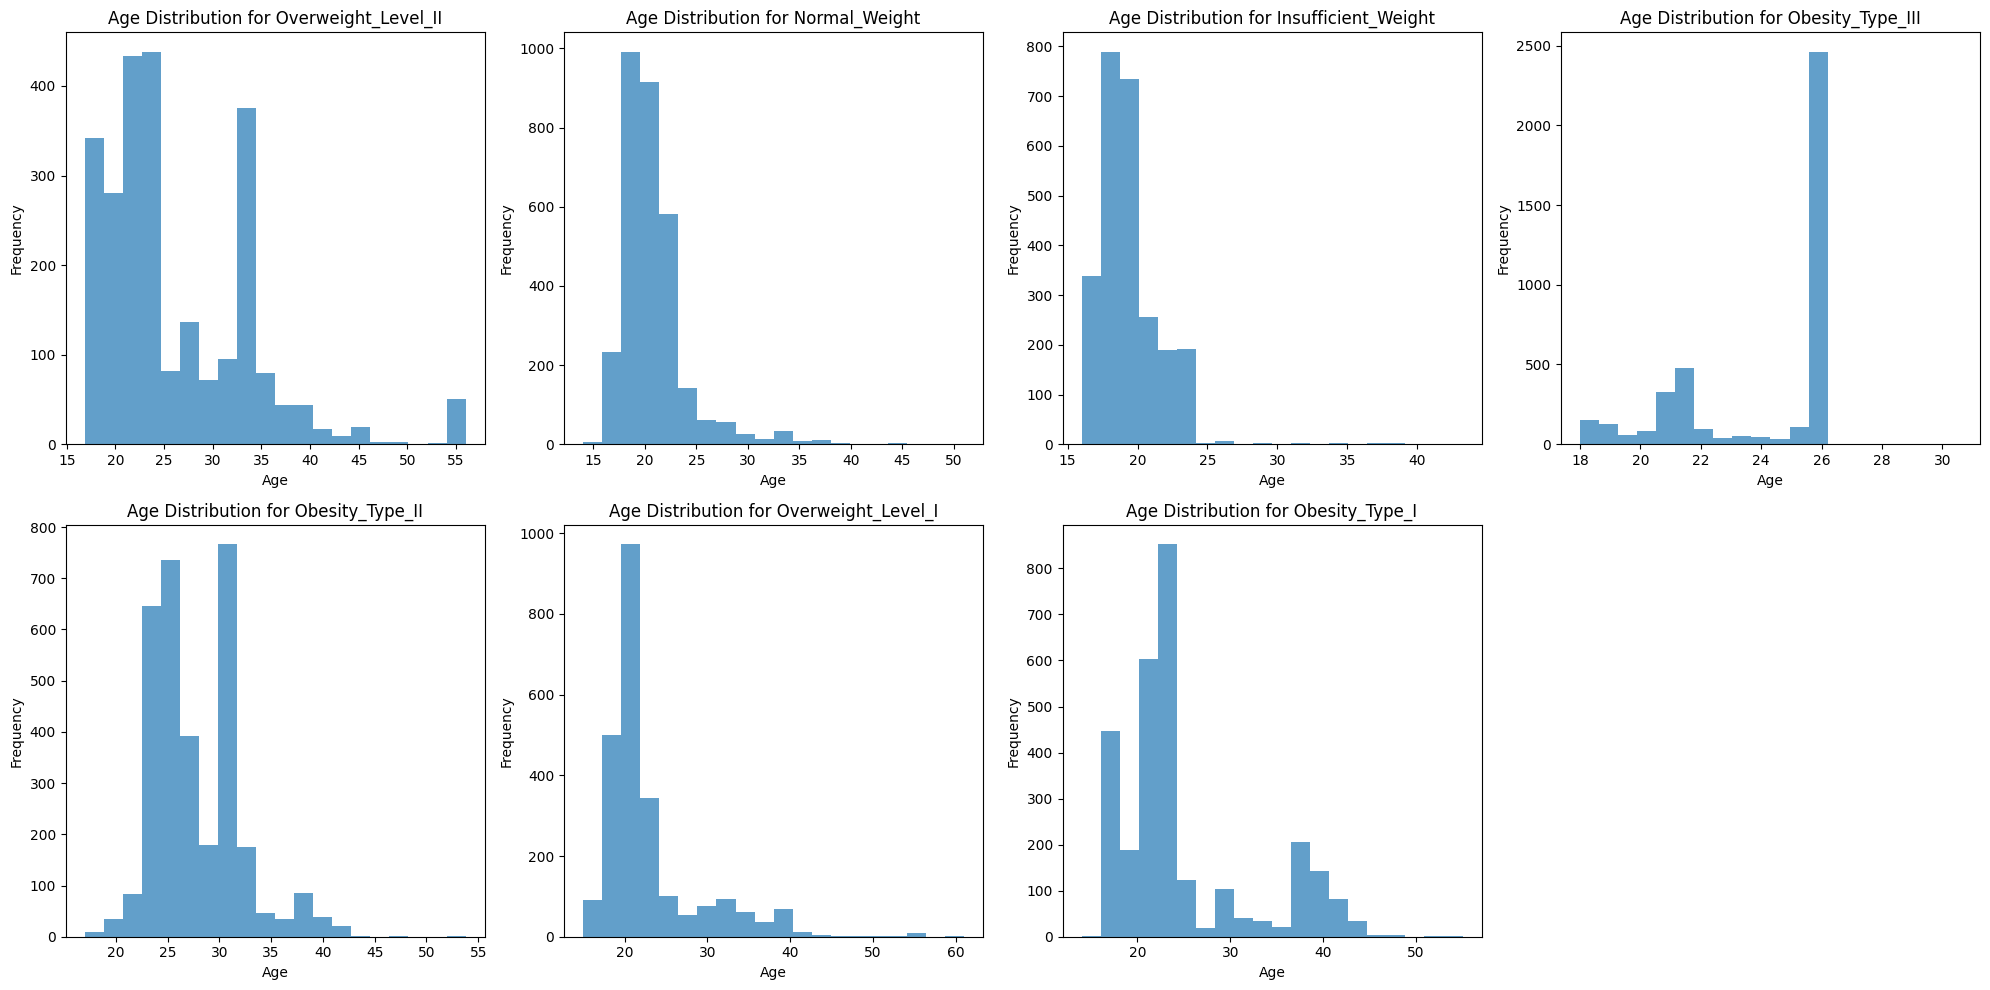

In [7]:
# Visualize the age distribution for each level of obesity in the training data.
unique_categories = df['NObeyesdad'].unique()
print(unique_categories)
plt.figure(figsize=(20,10))

for i, category in enumerate(unique_categories, start=1):
    category_data = df[df['NObeyesdad'] == category]['Age']
    plt.subplot(2, 4, i)
    plt.hist(category_data, bins=20, alpha=0.7)
    plt.title(f'Age Distribution for {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    

plt.tight_layout()    
plt.show()

# Introduction
<div style="font-size:120%"> 
    <b>Goal:</b> We have to predict obesity risk in individuals.<br><br>
    <b>Dataset Description:</b>
</div>

| Column | Full Form | Description| 
|---|---|---|
| 'id'| id | Unique for each person(row)|
|'Gender'| Gender| person's Gender|
| 'Age' | Age| Dtype is float. Age is between 14 years to 61 years |
|'Height'| Height | Height is in meter it's between 1.45m to 1.98m|
| 'Weight' | Weight| Weight is between 39 to 165. I think it's in KG.|
|'family_history_with_overweight'| family history <br> with overweight| yes or no question|
| 'FAVC'| Frequent consumption <br> of high calorie food| it's yes or no question. i think question they asked is <br>do you consume high calorie food|
|'FCVC'|  Frequency of <br>consumption of vegetables| Similar to FAVC. this is also `yes or no` question|
|'NCP'| Number of main meals| dtype is float, NCP is between 1 & 4. I think it should be 1,2,3,4 <br>but our data is synthetic so it's taking float values|
|'CAEC'| Consumption of <br>food between meals| takes 4 values `Sometimes`, `Frequently`, `no` & `Always` <br>|
| 'SMOKE'| Smoke | yes or no question. i think the question is "Do you smoke?" |
|'CH2O'| Consumption of <br>water daily| CH2O takes values between 1 & 3. again it's given as <br>float may be because of synthetic data. it's values should be 1,2 or 3|
|'SCC'|  Calories consumption <br>monitoring| yes or no question|
|'FAF'| Physical activity <br>frequency| FAF is between 0 to 3, 0 means no physical activity<br> and 3 means high workout. and again, in our data it's given as float|
|'TUE'| Time using <br>technology devices| TUE is between 0 to 2. I think question will be "How long you have <br>been using technology devices to track your health." in our data it's given as float |
|'CALC'| Consumption of alcohol | Takes 3 values: `Sometimes`, `no`, `Frequently`|
| 'MTRANS' | Transportation used| MTRANS takes 5 values `Public_Transportation`, `Automobile`, <br>`Walking`, `Motorbike`, & `Bike`|
|'NObeyesdad'| TARGET | This is our target, takes 7 values, and in this comp. we have to give <br>the class name (Not the Probability, which is the case in most comp.)


<div style="font-size:120%"> 
    <b>NObeyesdad (Target Variable):</b>
</div>

* Insufficient_Weight : Less than 18.5
* Normal_Weight       : 18.5 to 24.9
* Obesity_Type_I      : 30.0 to 34.9
* Obesity_Type_II     : 35.0 to 39.9
* Obesity_Type_III   : Higher than 40
* Overweight_Level_I, Overweight_Level_II takes values between 25 to 29



In [8]:
# Split the training data into X (features, independent variables) and y (labels, dependent variables).
labels = pd.DataFrame(df['NObeyesdad'])
features = df.drop('NObeyesdad', axis=1)

# 2.Data exploration and pre-processing

### Numerical DataFrame

In [9]:
# Separate the numerical columns from the independent variables. df_numerical contains the numerical columns before normalization.
mask_numeric = features.dtypes == float
df_numerical = features.loc[:, mask_numeric]

df_numerical

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
id,,,,,,,,,
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,28.259565
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,23.422091
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,17.126706
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,44.855798
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,25.599151
...,...,...,...,...,...,...,...,...,...
20753,25.137087,1.766626,114.187096,2.919584,3.000000,2.151809,1.330519,0.196680,36.587084
20754,18.000000,1.710000,50.000000,3.000000,4.000000,1.000000,2.000000,1.000000,17.099278
20755,20.101026,1.819557,105.580491,2.407817,3.000000,2.000000,1.158040,1.198439,31.889841


In [ ]:
## Mean and variance of numeric columns before normalization
print('mean of features')
print(df_numerical.mean())
print('\nvariance of features')
print(df_numerical.var())

In [ ]:
# Start Scale -> Use StandardScaler

#Creating objects
scaler = StandardScaler()
scaler.fit(df_numerical)

numerical_scaled = scaler.transform(df_numerical)
df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

print('mean of features')
print(df_numerical_scaled.mean())
print('\nvariance of features')
print(df_numerical_scaled.var())


In [ ]:
# Identify outliers -> but Outliers do not remove them because they are meaningful outliers.
# Calculate the number of outliers for each numeric columns
outliers = pd.DataFrame(index=df_numerical.columns, columns=["Has Outliers", "Outlier Count"])

for column in df_numerical.columns:
    Q1 = df_numerical[column].quantile(0.25)
    Q3 = df_numerical[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_count = ((df_numerical[column] < lower_bound) | (df_numerical[column] > upper_bound)).sum()
    
    outliers.loc[column, "Has Outliers"] = outlier_count > 0
    outliers.loc[column, "Outlier Count"] = outlier_count

print(outliers)


### Categorical DataFrame

In [ ]:
# Extract only categorical columns and see the number of elements in each column
mask_categorical = features.dtypes != float
df_categorical = features.loc[:, mask_categorical]

for i in range(df_categorical.shape[1]):
    print(df_categorical.iloc[:, i].value_counts())


# 3. Encoding

In [ ]:
# Categorical column encoding
df_encoded = df_categorical.copy(deep=True)

# Label encoding
df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
df_encoded['family_history_with_overweight'] = df_encoded['family_history_with_overweight'].map({'no':0, 'yes':1})
df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes': 1, 'Frequently':2, 'Always':3})
df_encoded['MTRANS'] = df_categorical['MTRANS'].map({'Automobile':0, 'Bike':1, 'Motorbike':2, 'Public_Transportation':3, 'Walking':4})

df_encoded

### Concatenate all features together

In [ ]:
# df_all_features is an independent variable dataframe in which both scale and encoding are finally completed
df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

df_all_features

### Define a pre_processing pipeline
Let us summarize all the previous steps into a function, called 'apply_preprocessing'

In [ ]:
# Creating above preprocessing code as pipeline function code -> Will be used to preprocesse independent variables of test data.
def apply_preprocessing(data):
    features = data.copy(deep=True)
    # numerical dataframe
    mask_numeric = features.dtypes == float
    df_numerical = features.loc[:, mask_numeric]
    
    # categorical dataframe
    mask_categorical = features.dtypes != float
    df_categorical = features.loc[:, mask_categorical]
   
    numerical_scaled = scaler.transform(df_numerical)
    df_numerical_scaled = pd.DataFrame(data=numerical_scaled, columns=df_numerical.columns)

    # label encoding
    df_encoded = df_categorical.copy(deep=True)
    df_encoded['Gender'] = df_categorical['Gender'].map({'Male':0, 'Female':1})
    df_encoded['family_history_with_overweight'] = df_categorical['family_history_with_overweight'].map({'no':0, 'yes':1})
    df_encoded['FAVC'] = df_categorical['FAVC'].map({'no':0, 'yes':1})
    df_encoded['CAEC'] = df_categorical['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['SMOKE'] = df_categorical['SMOKE'].map({'no':0, 'yes':1})
    df_encoded['SCC'] = df_categorical['SCC'].map({'no':0, 'yes':1})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['CALC'] = df_categorical['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
    df_encoded['MTRANS'] = df_categorical['MTRANS'].map({'Automobile':0, 'Bike':1, 'Motorbike':2, 'Public_Transportation':3, 'Walking':4})
    
    df_numerical_scaled.reset_index(drop=True, inplace=True)
    df_encoded.reset_index(drop=True, inplace=True)

    df_all_features = pd.concat([df_numerical_scaled, df_encoded], axis = 1)

    
    return df_all_features


### Compare train and test dataset
The train dataset is that one that we will use to train the model. It has labels.
The test dataset will be used to make predictions and submit them to the competition.

In [ ]:
# Import test data. The entire test data file becomes an independent variable.
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv', index_col = 0)
df_test["BMI"] = df_test["Weight"]/(df_test["Height"]*df_test["Height"])

# Encoding and applying scale using the preprocessed pipeline function 'apply_preprocessing' created above
df_test = apply_preprocessing(df_test)

print('Train columns', df_all_features.columns)
print('Test columns', df_test.columns)
print(df_test.head())
assert all(df_test.columns == df_all_features.columns), "Column in train and test dataset must be the same"

### Labels

In [ ]:
# labels are the dependent columns of the train data
labels['NObeyesdad'].unique()

In [ ]:
# Encoding the value of labels
labels_encoded = labels.copy(deep=True)

dict_conversion = {'Insufficient_Weight':0,
                   'Normal_Weight':1,
                   'Overweight_Level_I':2,
                   'Overweight_Level_II':3,
                   'Obesity_Type_I':4,
                   'Obesity_Type_II':5,
                   'Obesity_Type_III':6}

labels_encoded['NObeyesdad'] = labels_encoded['NObeyesdad'].map(dict_conversion)
labels_encoded.value_counts()


# 4.Prepare data for machine learning

In [ ]:

# X is the independent variable of the train data, y is the dependent variable of the train data
X = df_all_features.loc[: , ["BMI", "Height", "Weight", "FCVC", "CH2O", "NCP", "FAF", "TUE", "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]]
# When training a machine learning model, it is often safe to use np.label() to transform the target variable into a one-dimenstional array.
y = np.ravel(labels_encoded)

# compare train and test data
# X_test is the independent variable of the test data
X_test = df_test.loc[: , ["BMI", "Height", "Weight", "FCVC", "CH2O", "NCP", "FAF", "TUE", "Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC","MTRANS"]]
assert all(X_test.columns == X.columns), "Columns of trainging and test data must be the same"

print('Number of samples', len(X))
print('Number of featires', X.shape[1])

# Distribute training data to create validation data
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



## Fit the data with baseline models

In [ ]:
# First, measure the accuracy using four models as default values.
# Use Gradient Boost, Random Forest, LightGBM, XGBoost
clf1 = GradientBoostingClassifier()
clf2 = RandomForestClassifier(class_weight='balanced')
clf3 = LGBMClassifier(class_weight='balanced')
clf4 = XGBClassifier()

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)
clf4.fit(X_train, y_train)

In [ ]:
# Function that evaluate accuracy using X_train and X_validation
def evaluate_model(clf):
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_validation)
    train_score = np.mean(y_pred_train == y_train)
    validation_score = np.mean(y_pred_test == y_validation)
    
    print('Train score', round(train_score, 3))
    print('Test score', round(validation_score, 3))
    
    if train_score - validation_score > 0.05:
        print('Overfitting detected')
    
    print('=========================================')

In [ ]:
print('Random Forest')
evaluate_model(clf2)

print('LightGBM')
evaluate_model(clf3)

print('Gradient Boosting')
evaluate_model(clf1)

print('XGBoost')
evaluate_model(clf4)

# 5. Hyperparameter tuning
We fine_tune the XGBoost Classifier, LightGBM defined in the previous section, using the optimizer framework called Optuna

In [ ]:
# Hyperparameter tuning(XGBoost and LightGBM parameters are tuned at once -> takes a long time)
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 4, 10)
    n_estimators = trial.suggest_int('n_estimators', 500, 2000)
    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 0, 10)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0, 1)
    
    print('Training the model with', X.shape[1], 'features')
    
    # XGBoost 
    if trial.suggest_categorical('model', ['xgboost', 'lightgbm']) == 'xgboost':
        params = {'n_estimators': n_estimators,
                  'learning_rate': learning_rate,
                  'gamma': gamma,
                  'reg_alpha': reg_alpha,
                  'reg_lambda': reg_lambda,
                  'max_depth': max_depth,
                  'min_child_weight': min_child_weight,
                  'subsample': subsample,
                  'colsample_bytree': colsample_bytree,
                  'eval_metric':'mlogloss'}

        clf = XGBClassifier(**params)
   
    # LightGBM
    else:
        params = {'learning_rate': learning_rate,
                  'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'lambda_l1': reg_alpha,
                  'lambda_l2': reg_lambda,
                  'colsample_bytree': colsample_bytree, 
                  'subsample': subsample,    
                  'min_child_samples': min_child_weight,
                  'class_weight': 'balanced'}

        clf = LGBMClassifier(**params, verbose = -1, verbosity = -1)
    
    # cross-validation
    cv_results = cross_validate(clf, X, y, cv=5, scoring='accuracy')
    
    validation_score = np.mean(cv_results['test_score'])
    
    return validation_score

In [ ]:
# Uncomment this section if you want to do hyperparameter tuning
# Hyperparameter tuning start code
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

In [ ]:
# Hyperparameter result output
# in the order of the highest accuracy
df_study = study.trials_dataframe()
df_study = df_study.sort_values(by='value', ascending=False)

df_study

In [ ]:
# XGBoost Optimal Hyperparameter Output
print("Best params for XGBoost:")
xgboost_params = df_study[df_study['params_model'] == 'xgboost'].iloc[0]
xgboost_params.pop('number')  # 'number' key remove
xgboost_params.pop('value')  # 'value' key remove
xgboost_params.pop('datetime_start')  # 'datetime_start' key remove
xgboost_params.pop('datetime_complete')  # 'datetime_complete' key remove
xgboost_params.pop('duration')  # 'duration' key remove
xgboost_params.pop('state')  # 'state' key remove
xgboost_params.pop('params_model') # 'params_model' key remove


best_params_XGB = {key.replace('params_',''): value for key, value in xgboost_params.items()}
print(best_params_XGB)

# LightGBM Optimal Hyperparameter Output
print("\nBest params for LightGBM:")
lightgbm_params = df_study[df_study['params_model'] == 'lightgbm'].iloc[0]
lightgbm_params.pop('number')  # 'number' key remove
lightgbm_params.pop('value')  # 'value' key remove
lightgbm_params.pop('datetime_start')  # 'datetime_start' key remove
lightgbm_params.pop('datetime_complete')  # 'datetime_complete' key remove
lightgbm_params.pop('duration')  # 'duration' key remove
lightgbm_params.pop('state')  # 'state' key remove
lightgbm_params.pop('params_model') # 'params_model' key remove

best_params_LGBM = {key.replace('params_', ''):value for key, value in lightgbm_params.items()}
best_params_LGBM

In [ ]:
# Collection of models to use as a base model in stacking
base_models = [
    ('xgboost', XGBClassifier(**best_params_XGB)),
    ('lightgbm', LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity=-1)),
]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=27)
#  2 models above as estimators, using logistic regression as final_estimator
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

stacking_model.fit(X_train, y_train)

In [ ]:
# Estimate the accuracy of the final stacking model(Using validation data)

y_pred_val = stacking_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(accuracy_val)

In [ ]:
# Expect dependent variables in test data as final stacking model
y_pred_test = stacking_model.predict(X_test)
y_pred_test[:10]

In [ ]:
# Transformation for Submission
# If you want to submit the results using stacking, you can submit this.
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = y_pred_test
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)
print(df_submission)
df_submission.to_csv('submission_stacking(XGB_LGBM).csv')



## 6. Try to improve accuracy using cross validation
In this section we use a tuned XGBoost or LightGBM together with cross-validation. We make 5 predictions for each sample and then we compute the average probability to assign the label

In [ ]:

def train_evaluate_model(X, y, X_test):
    # use Stratified KFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(X, y)

    scores = []
    predictions = []
    clfs = []

    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        print('Fitting with k-fold', i+1, 'out of', len(train_index))
        X_train = np.array(X)[train_index, :]
        y_train = np.array(y)[train_index]
        X_val = np.array(X)[val_index, :]
        y_val = np.array(y)[val_index]
        
        print('Training on', len(X_train), 'samples')
        print('Evaluating on', len(X_val), 'samples')
        
        clf = XGBClassifier(**best_params_XGB)
        clf.fit(X=X_train, y=y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)],
                early_stopping_rounds=10,
                verbose=50)
        
        # If you want to use LightGBM instead of XGBoost, use the comment code below
        #clf = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
        #clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
        
        y_pred_val = clf.predict(X_val)

        new_score = accuracy_score(y_val, y_pred_val)
        print('validation score is', new_score)
        scores.append(new_score)

        # store predictions
        y_pred_test_proba = clf.predict_proba(X_test)
        predictions.append(y_pred_test_proba)
        print('Round', i+1, 'Predictions stored successfully')
        
        clfs.append(clf)
        
    return scores, np.array(predictions), clfs

In [ ]:
scores, predictions, clfs = train_evaluate_model(X, y, X_test)

In [ ]:
print('Average evaluation score = ', np.mean(scores))

In [ ]:
y_test_pred = np.mean(predictions, axis=0)
y_test_pred = np.argmax(y_test_pred, axis=1)

y_test_pred

In [ ]:
# If you want to submit the results using cross-validation, you can submit this.
df_submission['NObeyesdad'] = y_test_pred
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)

print(df_submission)

df_submission.to_csv('submission_XGB_cross_Val.csv')


In [ ]:
results = clfs[0].evals_result()

train_loss = results['validation_0']['mlogloss']
validation_loss = results['validation_1']['mlogloss']
epochs_grid = np.arange(1, len(train_loss)+1)

plt.plot(epochs_grid, train_loss, label='Training')
plt.plot(epochs_grid, validation_loss, label='Validation')
plt.legend()
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.grid()

## 8. Use this when using voting!/ Use lgbm, xgb, gb as voting algorithm
In this section we try to improve the accuracy using a voting classifier, consisting of the 3 following algorithms:

- GradientBoosting Classifier
- XGBoost
- LigthGBM

In [ ]:
clf_lgbm = LGBMClassifier(**best_params_LGBM, verbose = -1, verbosity = -1)
clf_xgb = XGBClassifier(**best_params_XGB)
clf_gb = GradientBoostingClassifier()
voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb', clf_xgb), ('gb', clf_gb)], 
                              voting='soft')

voting_clf.fit(X, y)

In [ ]:
# If you want to submit the results using voting, you can submit this.
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')
df_submission['NObeyesdad'] = voting_clf.predict(X_test)
reverse_dict_conversion = dict(zip(dict_conversion.values(), dict_conversion.keys()))
df_submission['NObeyesdad'] = df_submission['NObeyesdad'].map(reverse_dict_conversion)
df_submission.set_index('id', inplace=True)

print(df_submission)

df_submission.to_csv('submission_Voting(lgbm_xgb_gb).csv')